The purpose of this notebook is to find various sub-populations in the larger dataset.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
# # the "1" means: always reload modules marked with "%aimport"
%autoreload 2

from __future__ import absolute_import, division, print_function
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
# from tqdm import tqdm
# import warnings

# sns.set_context("poster", font_scale=0.9)
sns.set_context("notebook", font_scale=1.0)
pd.set_option('display.max_columns', 100)

# add the data functions to the path
src_data_dir = os.path.join(os.getcwd(), os.pardir, 'src/data')
sys.path.append(src_data_dir)

# functions to load the data
import dataset as ds

In [2]:
# load in and process the data in separate sheets

df_client = ds.process_data_client(simplify_strings=True)

df_enroll = ds.process_data_enrollment(simplify_strings=True)

# Only keep rows with entry dates starting in 2012
df_enroll = df_enroll[df_enroll['Entry Date'] >= '2012']
# Only keep rows with exit dates before 2016-06-01
df_enroll = df_enroll[df_enroll['Exit Date'] <= '2016-06-01']

df_disability = ds.process_data_disability(simplify_strings=True)

df_healthins = ds.process_data_healthins(simplify_strings=True)

df_benefit = ds.process_data_benefit(simplify_strings=True)

df_income = ds.process_data_income(simplify_strings=True)

df_project = ds.process_data_project(simplify_strings=True)

df_service = ds.process_data_service(simplify_strings=True)

df_bedinv = ds.process_data_bedinventory(simplify_strings=True)

# Join the client information with enrollment information.
# Inner join because we want to only keep individuals
# for whom we have both client and enrollment information.
df = df_client.merge(df_enroll, how='inner', left_index=True, right_index=True)

# just choose the first non-cash benefit; this is too simple!
# TODO: join on the exact Project ID, and possible Date
df = df.merge(df_benefit.reset_index().groupby(by=['Personal ID'])[['Non-Cash Benefit']].nth(0),
              how='left', left_index=True, right_index=True)
# # possible fix for above, but this isn't working properly (results in too many rows);
# # probably need date too, but they do not align
# df.reset_index().merge(df_benefit.reset_index()[['Personal ID', 'Project Entry ID', 'Non-Cash Benefit']].drop_duplicates(),
#                        how='left',
#                        on=['Personal ID', 'Project Entry ID'],
#                       ).drop_duplicates().set_index('Personal ID')

df['Non-Cash Benefit'] = df['Non-Cash Benefit'].fillna('None')

# add information about their disability status
# just choose the first disability; this is too simple!
# TODO: join on the exact Project ID
df = df.merge(df_disability.reset_index().groupby(by=['Personal ID'])[['Disability Type']].nth(0),
              how='left', left_index=True, right_index=True)
# # possible fix for above, but this isn't working properly (results in too many rows);
# # probably need date too, but they do not align
# df.reset_index().merge(df_disability.reset_index()[['Personal ID', 'Project Entry ID', 'Disability Type']].drop_duplicates(),
#                        how='left',
#                        on=['Personal ID', 'Project Entry ID'],
#                       ).drop_duplicates().set_index('Personal ID')

df['Disability Type'] = df['Disability Type'].fillna('None')

# add Project Type Code to DataFrame
df = df.merge(df_project[['Project Name',
                          'Project Type Code',
                          'Address City',
                          'Address Postal Code',
                         ]], left_on=['Project ID'], right_index=True)

# sort by entry date
df = df.sort_values('Entry Date')

# rename the columns to have no spaces
df = ds.rename_columns(df)

In [3]:
df.shape

(58209, 33)

In [5]:
df.head()

,race,ethnicity,gender,veteran_status,project_entry_id,client_age_at_entry,last_permanent_zip,entry_date,exit_date,project_id,housing_status_project_start,living_situation_before_program_entry,client_location,household_id,disabling_condition,continuously_homeless_one_year,times_homeless_past_three_years,months_homeless_this_time,chronic_homeless,in_permanent_housing,residential_move_in_date,domestic_violence_victim,months_ago_dv_occurred,dv_currently_fleeing,days_enrolled,days_to_residential_move_in,head_of_household,noncash_benefit,disability_type,project_name,project_type_code,address_city,address_postal_code
Personal ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
214224,white,nonlatino,male,False,203474,60,00000,2012-01-01,2013-09-08,2938,cat1homeless,hotel,NaN,203474,True,False,NaN,NaN,False,False,NaT,False,NaN,False,616,NaN,False,None,physical,SCz - HSC - Page Smith Community House,transitionalhousing,Santa Cruz,95060
194592,white,nonlatino,male,True,150135,53,91103,2012-01-02,2013-08-31,2134,cat1homeless,family,NaN,150135,True,False,NaN,NaN,False,False,NaT,False,NaN,False,607,NaN,False,foodstamps,mentalhealth,MOSBE Veterans Transition Center - Outreach,other,Marina,93933
179384,white,latino,female,False,155873,50,93245,2012-01-03,2016-01-28,2086,cat1homeless,streets,CA-506,155873,False,False,NaN,NaN,False,False,NaT,False,NaN,False,1486,NaN,True,None,None,MOSBE The Salvation Army - Good Samaritan Center,servicesonly,NaN,93955
183019,white,latino,male,False,155872,28,93950,2012-01-03,2012-10-26,2086,cat1homeless,streets,CA-506,155872,False,False,NaN,NaN,False,False,NaT,False,NaN,False,297,NaN,False,None,None,MOSBE The Salvation Army - Good Samaritan Center,servicesonly,NaN,93955
182885,black,nonlatino,male,False,153810,48,93911,2012-01-04,2013-05-02,2086,cat1homeless,emershelter,NaN,153810,False,False,NaN,NaN,False,False,NaT,False,NaN,False,484,NaN,False,None,None,MOSBE The Salvation Army - Good Samaritan Center,servicesonly,NaN,93955


# One-hot encoding

In [6]:
features_binary = [
    'veteran_status',
    'disabling_condition',
    'continuously_homeless_one_year',
    'chronic_homeless',
    'in_permanent_housing',
    'domestic_violence_victim',
    'dv_currently_fleeing',
    'head_of_household',
]

features_quant = [
    'client_age_at_entry',
    'times_homeless_past_three_years',
    'months_homeless_this_time',
    'months_ago_dv_occurred',
    'days_enrolled',
    'days_to_residential_move_in',
]

features_date = [
    'entry_date',
    'exit_date',
    'residential_move_in_date',
    ]

features_one_hot = [
    'race',
    'ethnicity',
    'gender',
    'housing_status_project_start',
    'living_situation_before_program_entry',
    'noncash_benefit',
    'disability_type',
    'project_type_code',
]

features_not_using = [
    'project_entry_id',
    'last_permanent_zip',
    'project_id',
    'client_location',
    'household_id',
    'project_name',
    'address_city',
    'address_postal_code',
]

In [7]:
df = df.drop(features_not_using, axis=1)

df, cols = ds.encode_categorical_features(df, features_one_hot, astype='int')

In [8]:
# set up to count the number of times a person was in the system
df['enrollments'] = 1

# for each person, calculate the mean for their one-hot encoded features
agg_one_hot = {}
for col in cols:
    agg_one_hot[col] = 'mean'

# create feature vectors for each person by subselecting or aggregating their enrollments;
# one row per person
agg = {
    # binary
    'veteran_status': 'max',
    'disabling_condition': 'max',
    'continuously_homeless_one_year': 'max',
    'chronic_homeless': 'max',
    'domestic_violence_victim': 'max',
    'dv_currently_fleeing': 'max',
    'head_of_household': 'max',
    # quantitative
    'enrollments': 'sum',
    'client_age_at_entry': 'last',
    'times_homeless_past_three_years': 'last',
    'months_homeless_this_time': 'last',
    'months_ago_dv_occurred': 'last',
    'days_enrolled': 'sum',
    #     # categorical
    #     'race': 'first',
    #     'ethnicity': 'first',
    #     'gender': 'first',
    #     'housing_status_project_start': 'last',
    #     'living_situation_before_program_entry': 'last',
    #     'non_cash_benefit': 'last',
    #     'disability_type': 'last',
    #     'project_type_code': 'last',
    # outcome related
    'in_permanent_housing': 'last',
    'days_to_residential_move_in': 'last',
    }
agg.update(agg_one_hot)
df_features = df.reset_index().groupby(by=['Personal ID']).agg(agg)

# convert booleans to integers
for col in features_binary:
    df_features[col] = df_features[col].astype(int)

In [9]:
# number of people in the dataset
df_features.shape

(11362, 88)

In [11]:
# glance at the data
df_features[sorted(df_features.columns)].head()

,chronic_homeless,client_age_at_entry,continuously_homeless_one_year,days_enrolled,days_to_residential_move_in,disability_type_alcohol,disability_type_alcoholdrug,disability_type_chronichealth,disability_type_developmental,disability_type_drug,disability_type_hivaids,disability_type_mentalhealth,disability_type_none,disability_type_physical,disability_type_substance,disabling_condition,domestic_violence_victim,dv_currently_fleeing,enrollments,ethnicity_latino,ethnicity_nonlatino,ethnicity_unknown,gender_female,gender_male,gender_other,gender_transftom,gender_transmtof,gender_unknown,head_of_household,housing_status_project_start_atrisk,housing_status_project_start_cat1homeless,housing_status_project_start_cat2risklosing,housing_status_project_start_cat3homelessfedstatutes,housing_status_project_start_cat4fleeingdv,housing_status_project_start_housed,housing_status_project_start_unknown,in_permanent_housing,living_situation_before_program_entry_detoxcenter,living_situation_before_program_entry_emershelter,living_situation_before_program_entry_family,living_situation_before_program_entry_foster,living_situation_before_program_entry_friend,living_situation_before_program_entry_halfwayhouse,living_situation_before_program_entry_hospital,living_situation_before_program_entry_hospitalpsych,living_situation_before_program_entry_hotel,living_situation_before_program_entry_jail,living_situation_before_program_entry_longtermcare,living_situation_before_program_entry_other,living_situation_before_program_entry_owned,living_situation_before_program_entry_ownedsubsidy,living_situation_before_program_entry_permanenthousing,living_situation_before_program_entry_rental,living_situation_before_program_entry_rentalgdptip,living_situation_before_program_entry_rentalother,living_situation_before_program_entry_rentalvash,living_situation_before_program_entry_safehaven,living_situation_before_program_entry_streets,living_situation_before_program_entry_transitionalhousing,living_situation_before_program_entry_unknown,months_ago_dv_occurred,months_homeless_this_time,noncash_benefit_foodstamps,noncash_benefit_none,noncash_benefit_other,noncash_benefit_publichousing,noncash_benefit_tanfchildcare,noncash_benefit_tanfother,noncash_benefit_tanftransportation,noncash_benefit_temprental,noncash_benefit_wic,project_type_code_emergencyshelter,project_type_code_homelessnessprevention,project_type_code_other,project_type_code_permanentsupportivehousing,project_type_code_rapidrehousing,project_type_code_servicesonly,project_type_code_streetoutreach,project_type_code_transitionalhousing,race_amerindian,race_asian,race_black,race_other,race_pacificisl,race_unknown,race_white,times_homeless_past_three_years,veteran_status
Personal ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
173781,0,35,0,147,NaN,0,0,0,0,0,0,0,1,0,0,0,1,0,2,1,0,0,1,0,0,0,0,0,0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,NaN,1,0,0,0,0,0,0,0,0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0,0,0,0,0,0,1,2.0,0
173782,0,10,1,147,NaN,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,NaN,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.0,0
173783,0,12,1,147,NaN,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,NaN,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.0,0
173803,0,32,0,78,NaN,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,NaN,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,NaN,0
173804,0,11,0,78,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0

In [12]:
df_features[sorted(df_features.columns)].describe()

,chronic_homeless,client_age_at_entry,continuously_homeless_one_year,days_enrolled,days_to_residential_move_in,disability_type_alcohol,disability_type_alcoholdrug,disability_type_chronichealth,disability_type_developmental,disability_type_drug,disability_type_hivaids,disability_type_mentalhealth,disability_type_none,disability_type_physical,disability_type_substance,disabling_condition,domestic_violence_victim,dv_currently_fleeing,enrollments,ethnicity_latino,ethnicity_nonlatino,ethnicity_unknown,gender_female,gender_male,gender_other,gender_transftom,gender_transmtof,gender_unknown,head_of_household,housing_status_project_start_atrisk,housing_status_project_start_cat1homeless,housing_status_project_start_cat2risklosing,housing_status_project_start_cat3homelessfedstatutes,housing_status_project_start_cat4fleeingdv,housing_status_project_start_housed,housing_status_project_start_unknown,in_permanent_housing,living_situation_before_program_entry_detoxcenter,living_situation_before_program_entry_emershelter,living_situation_before_program_entry_family,living_situation_before_program_entry_foster,living_situation_before_program_entry_friend,living_situation_before_program_entry_halfwayhouse,living_situation_before_program_entry_hospital,living_situation_before_program_entry_hospitalpsych,living_situation_before_program_entry_hotel,living_situation_before_program_entry_jail,living_situation_before_program_entry_longtermcare,living_situation_before_program_entry_other,living_situation_before_program_entry_owned,living_situation_before_program_entry_ownedsubsidy,living_situation_before_program_entry_permanenthousing,living_situation_before_program_entry_rental,living_situation_before_program_entry_rentalgdptip,living_situation_before_program_entry_rentalother,living_situation_before_program_entry_rentalvash,living_situation_before_program_entry_safehaven,living_situation_before_program_entry_streets,living_situation_before_program_entry_transitionalhousing,living_situation_before_program_entry_unknown,months_ago_dv_occurred,months_homeless_this_time,noncash_benefit_foodstamps,noncash_benefit_none,noncash_benefit_other,noncash_benefit_publichousing,noncash_benefit_tanfchildcare,noncash_benefit_tanfother,noncash_benefit_tanftransportation,noncash_benefit_temprental,noncash_benefit_wic,project_type_code_emergencyshelter,project_type_code_homelessnessprevention,project_type_code_other,project_type_code_permanentsupportivehousing,project_type_code_rapidrehousing,project_type_code_servicesonly,project_type_code_streetoutreach,project_type_code_transitionalhousing,race_amerindian,race_asian,race_black,race_other,race_pacificisl,race_unknown,race_white,times_homeless_past_three_years,veteran_status
count,11362.000000,11362.000000,11362.000000,11362.000000,747.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,1910.000000,1726.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,5202.000000,11362.000000
mean,0.059849,33.622250,0.185443,207.853459,72.552878,0.027196,0.038021,0.058704,0.012322,0.019275,0.014082,0.049375,0.748

In [13]:
# my gist from https://gist.github.com/warmlogic/afaf1d2b1ce90927d14f008571b6f6f0
import classify_utils as cu

In [14]:
df_model = df_features.copy()
df_model = df_model.apply(lambda x: x.fillna(x.median()),axis=0)

In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True)

In [16]:
outcome = 'in_permanent_housing'
y = df_model[outcome].values
X = df_model.drop(outcome, axis=1)

X = X.drop('days_to_residential_move_in', axis=1)

# X = X.apply(lambda x: x.fillna(x.median()),axis=0)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

In [24]:
print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

print(y_train.sum())

print(y_test.sum())

(5681, 86)
(5681, 86)
(5681,)
(5681,)
603
545



AUC: 0.96685
Precision: 0.7826
Recall: 0.6936
F1 score: 0.7354

Confusion Matrix
Prediction     0    1   All
Truth                      
0           5031  105  5136
1            167  378   545
All         5198  483  5681

Percent of outcomes classified
Prediction          0         1
Truth                          
0           96.787226  21.73913
1            3.212774  78.26087

Features, ranked by importance
                                                    importance       std
days_enrolled                                         0.122472  0.025894
project_type_code_rapidrehousing                      0.114898  0.066383
client_age_at_entry                                   0.075421  0.014017
veteran_status                                        0.054626  0.041534
times_homeless_past_three_years                       0.051781  0.018009
head_of_household                                     0.045230  0.027654
months_homeless_this_time                             0.043580  0.019847
pr

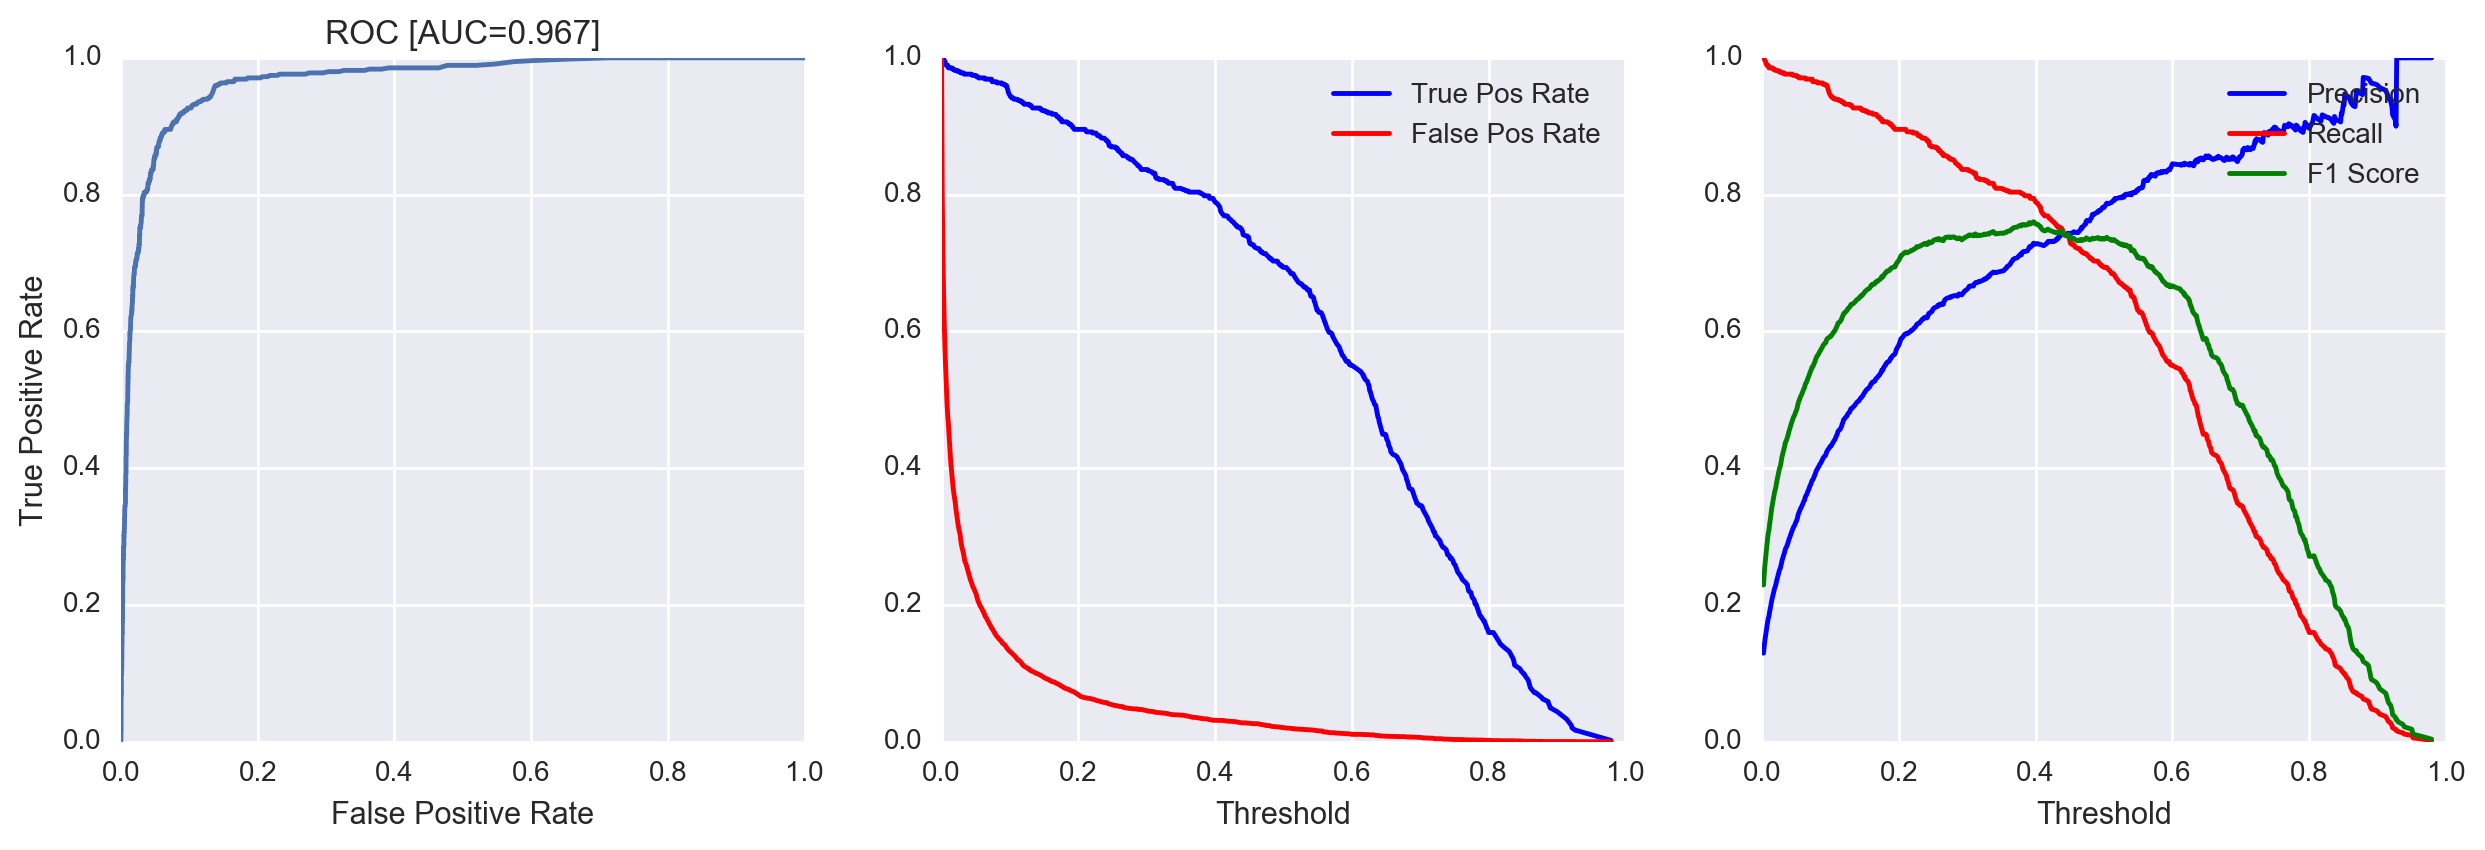

In [25]:
results, myAuc, precision, recall, f1, myModel = cu.classify(X_train, X_test, y_train, y_test, 'rf',
                                                            n_estimators=1000);

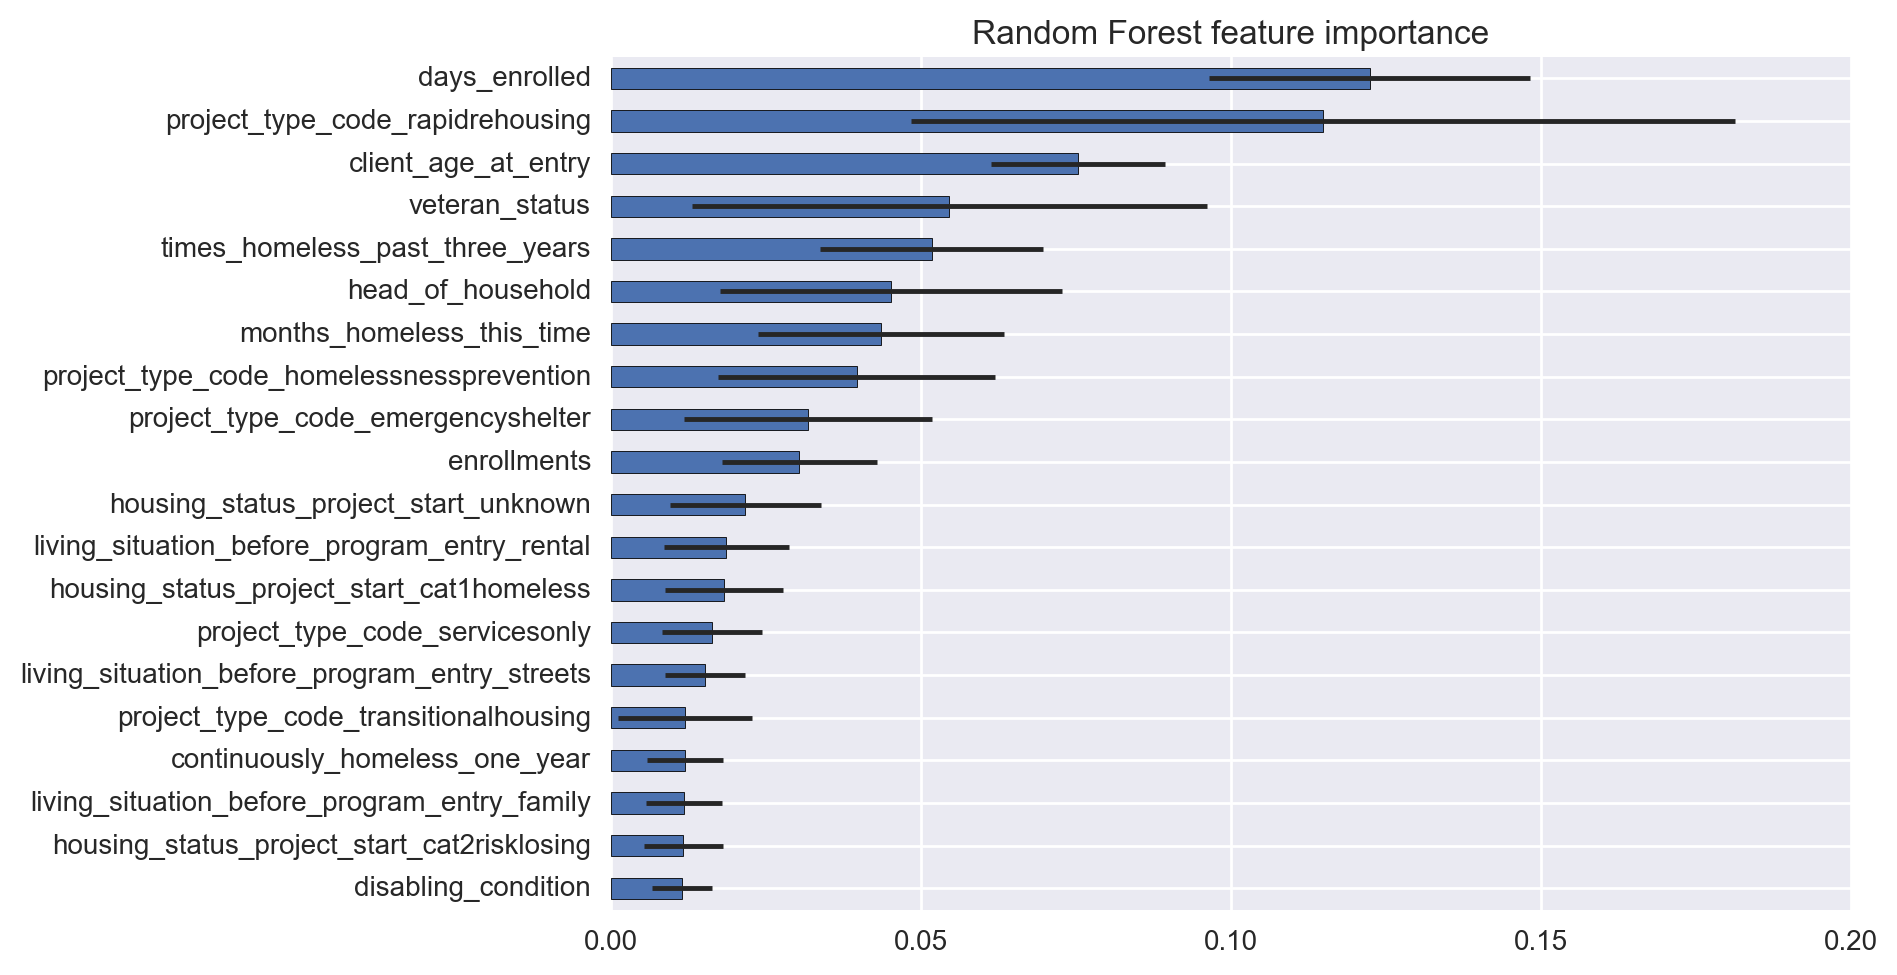

In [26]:
results = pd.DataFrame(myModel.feature_importances_, index=X_train.columns, columns=['importance'])
results['std'] = np.std([tree.feature_importances_ for tree in myModel.estimators_], axis=0)

results = results.sort_values(['importance'], ascending=False)

results = results.iloc[:20, :]

fig, ax = plt.subplots()
results['importance'].iloc[::-1].plot(kind='barh', xerr=results['std'].iloc[::-1], ax=ax);

ax.set(title='Random Forest feature importance',
      );

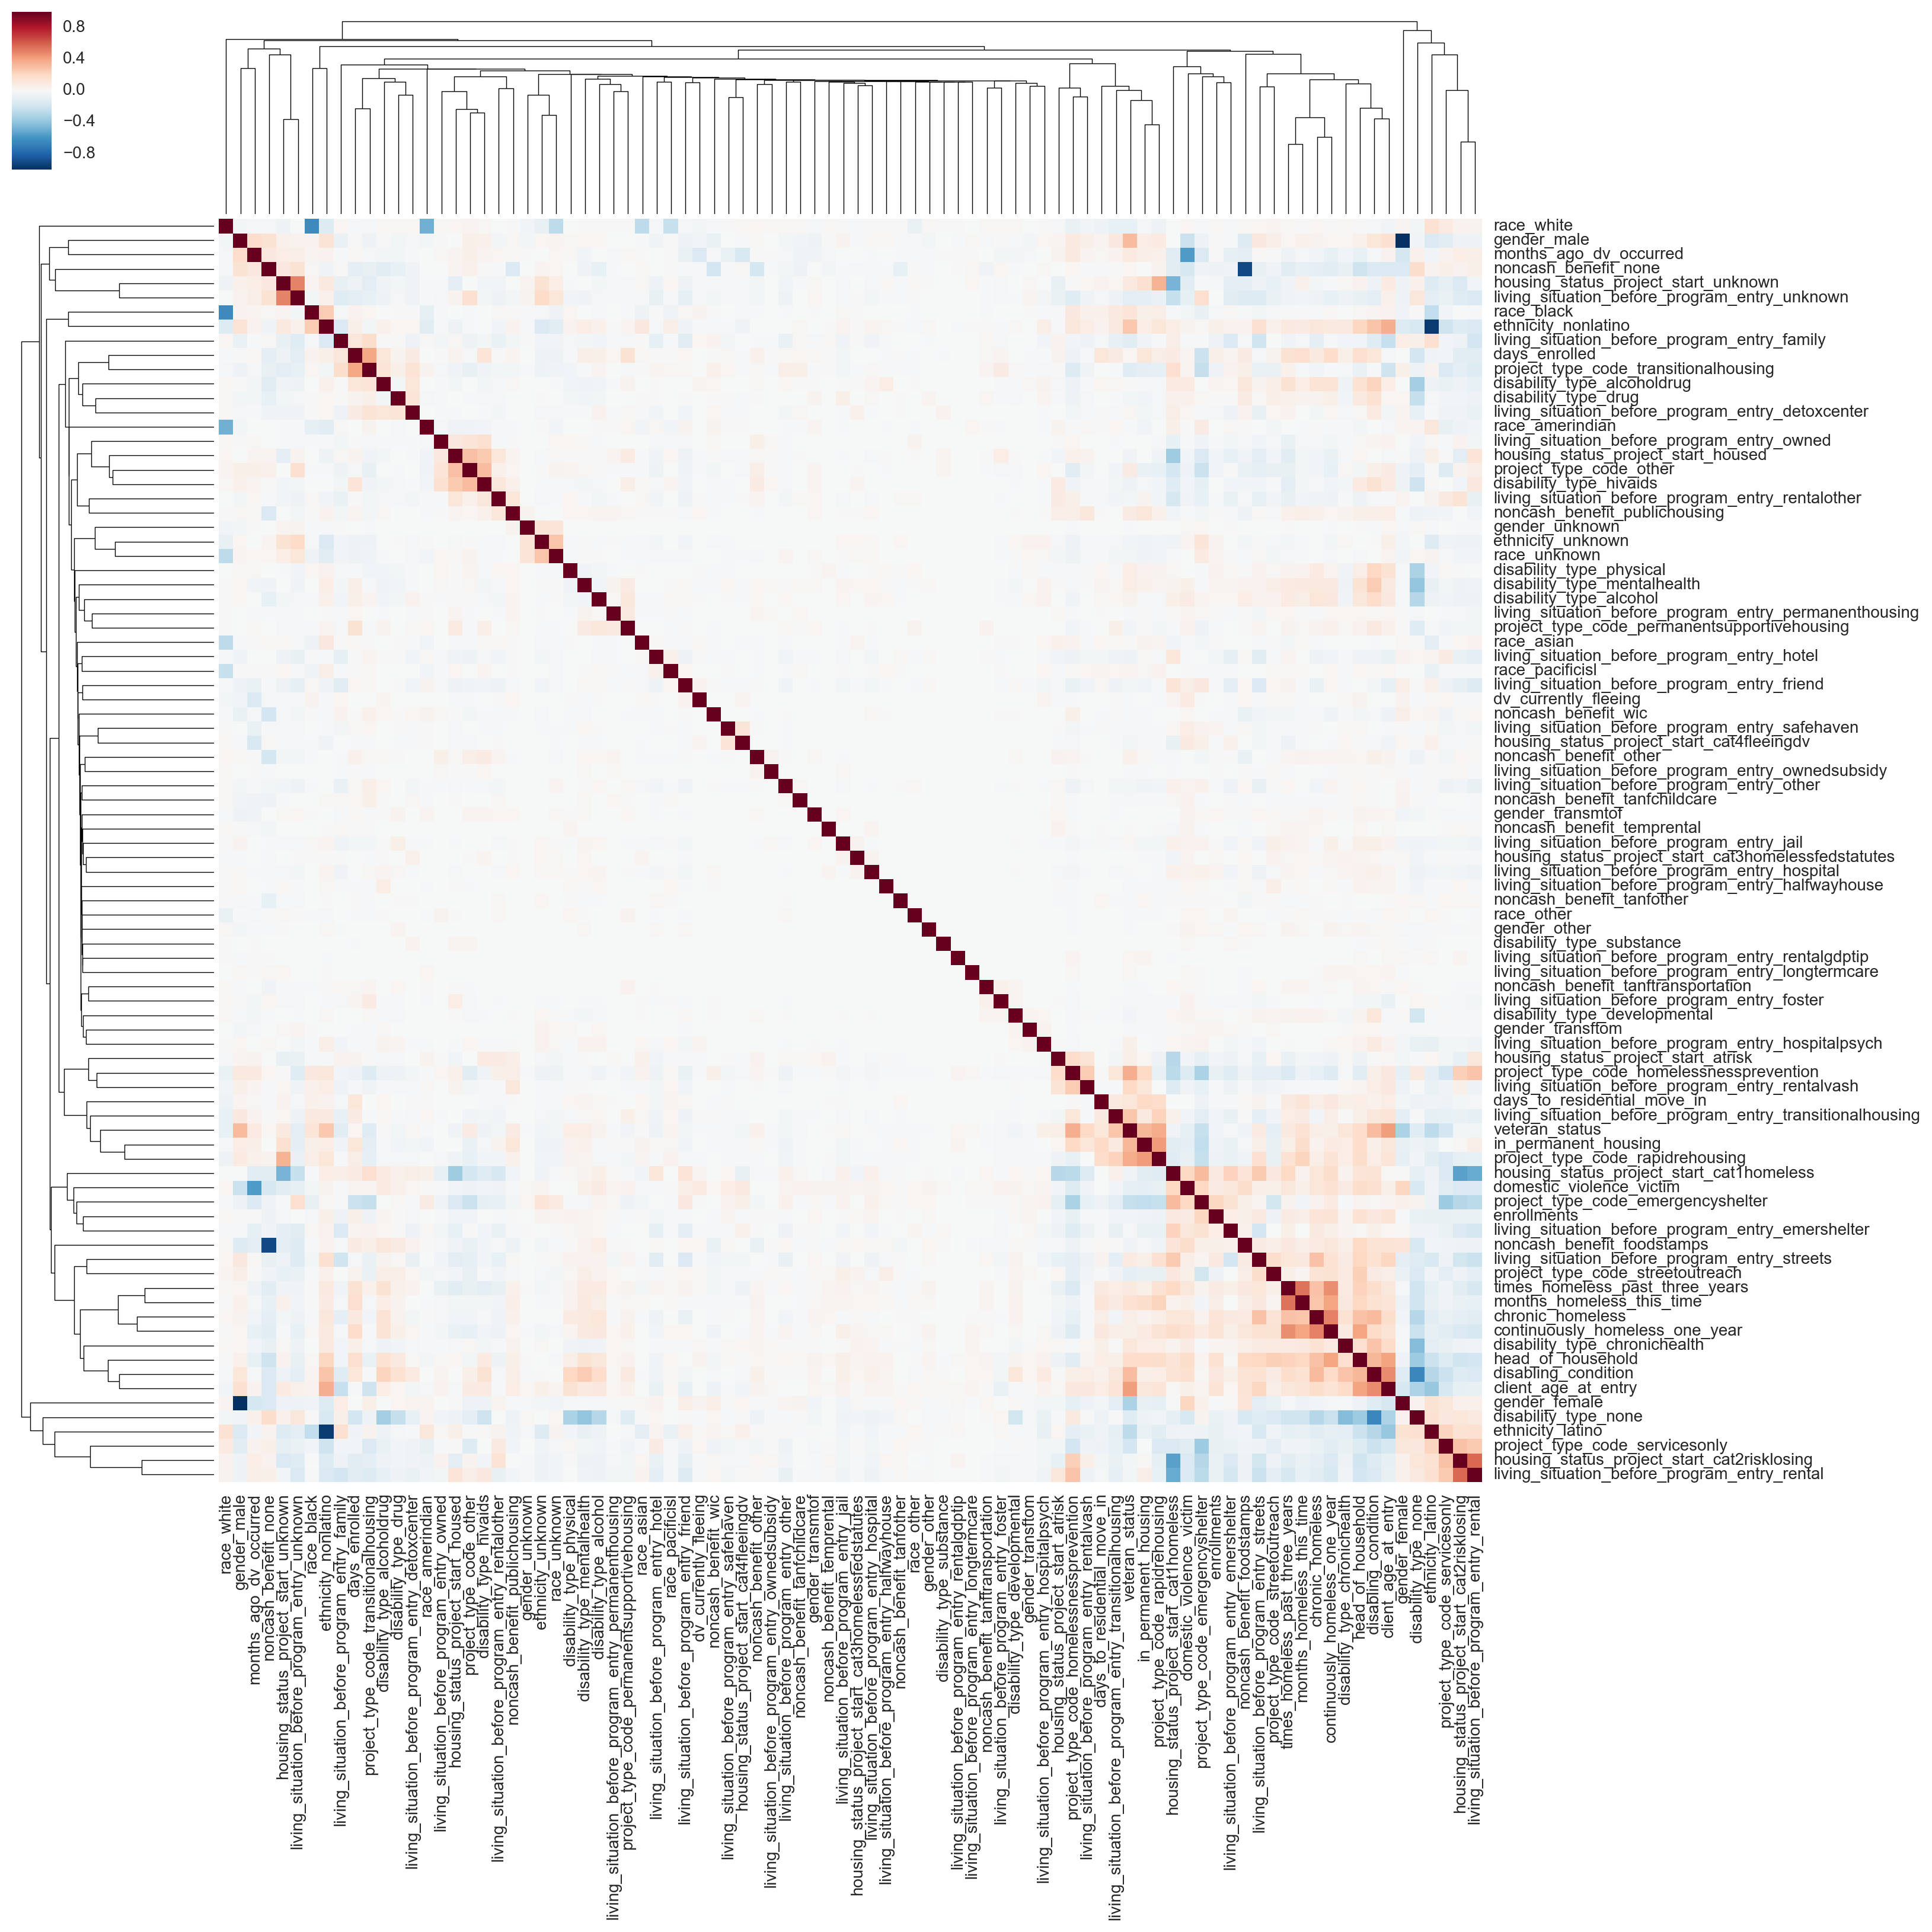

In [27]:
g = sns.clustermap(df_model.corr(), figsize=(16, 16));

plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

In [28]:
from sklearn.preprocessing import StandardScaler

def log_and_scale(df, features, features_to_log=None):
    '''Select only the columns we want,
    log transform specified columns,
    and standardize (mean=0, std=1).
    '''
    df_scaled = df[features].copy().astype('float')
    
    if features_to_log is not None:
        df_scaled[features_to_log] = df_scaled[features_to_log].apply(lambda x: np.log(x+1))

    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=features, index=df[features].index)


In [29]:
# get rid of some less important columns
outcome = ['in_permanent_housing', 'days_enrolled', 'days_to_residential_move_in']
df_model2 = df_model.drop(outcome, axis=1)

In [30]:
from sklearn.decomposition import PCA

def pca_fit(df, N_COMPONENTS=10):
    '''Fit a PCA model, keeping defined number of principal components
    '''
    myPCA = PCA(n_components=N_COMPONENTS)
    myPCA.fit(df)
    return myPCA

def pca_transform(df, myPCA):
    '''Transform data to PCA space, keeping defined number of principal components
    '''
    trans = myPCA.transform(df)
    return trans


In [31]:
N_COMPONENTS = 10
myPCA = pca_fit(df_model2, N_COMPONENTS=N_COMPONENTS)

In [32]:
trans = pca_transform(df_model2, myPCA)

In [33]:
# percentage explained by first N_COMPONENTS
print(myPCA.explained_variance_ratio_*100)
# sum of explained variance
print(myPCA.explained_variance_ratio_.sum())

[  5.46272295e+01   3.94274367e+01   2.87092900e+00   2.41409315e+00
   7.46647644e-02   6.73953168e-02   5.10857128e-02   4.40078598e-02
   4.36640135e-02   3.50730460e-02]
0.996555790627


In [34]:
dfpc = pd.DataFrame(myPCA.components_.T, index = df_model2.columns)

print_n=20
for pc in range(N_COMPONENTS):
    dfpc['abs'] = dfpc[pc].abs()
    print('#----------------- PC %d -----------------#' % (pc+1))
    print(dfpc.sort_values(by=['abs'], ascending=False)[pc][:print_n])
    print('\n')

#----------------- PC 1 -----------------#
client_age_at_entry                              0.874431
enrollments                                      0.483499
months_homeless_this_time                        0.030511
disabling_condition                              0.010366
months_ago_dv_occurred                           0.009801
head_of_household                                0.009574
ethnicity_latino                                -0.008397
ethnicity_nonlatino                              0.007974
veteran_status                                   0.006385
disability_type_none                            -0.006092
times_homeless_past_three_years                  0.005081
living_situation_before_program_entry_streets    0.004033
gender_female                                   -0.003476
living_situation_before_program_entry_family    -0.003463
gender_male                                      0.003362
continuously_homeless_one_year                   0.003287
noncash_benefit_none         

In [35]:
# df[df['Residential Move In Date'].notnull()]['In Permanent Housing'].value_counts()

In [36]:
# df['days_enrolled'].describe()

In [37]:
# df['days_enrolled'].quantile(.25)

In [38]:
# dim = 'days_enrolled'

# # 3IQR
# m = 4
# Q1 = df[dim].quantile(.25)
# Q3 = df[dim].quantile(.75)
# IQR = Q3 - Q1
# mIQR = [(Q1 - (m*IQR)), (Q3 + (m*IQR))]


In [39]:
# mIQR

In [40]:
# # number of entries and exits on each date
# fig, ax = plt.subplots()

# alpha = 0.5

# df['Entry Date'].value_counts().plot(ax=ax, label='Entry', alpha=alpha);
# df['Exit Date'].value_counts().plot(ax=ax, label='Exit', alpha=alpha);

# ax.legend();

In [41]:
# df['DV When Occurred'].value_counts()

In [42]:
# df.columns.tolist()